# Промежуточный проект e-commerce: вариант 1 

### Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз? 
2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?
3. По каждому товару определить, в какой день недели товар чаще всего покупается.
4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? 
5. Используя pandas, проведи когортный анализ пользователей.
В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

In [25]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.express as px

In [26]:
sns.set(
    font_scale=2, 
    style     ="whitegrid", 
    rc        = {'figure.figsize': (20, 7)}
)

# настроил график, где: font_scale - размер шрифта
#                       style - фон графика
#                       rc - размер фигур

In [49]:
custumers   = pd.read_csv('olist_customers_dataset.csv')
orders      = pd.read_csv('olist_orders_dataset.csv', 
                          parse_dates=['order_purchase_timestamp', 'order_approved_at',
                                       'order_delivered_carrier_date', 'order_delivered_customer_date',
                                      'order_estimated_delivery_date'])
order_items = pd.read_csv('olist_order_items_dataset.csv', 
                         parse_dates=['shipping_limit_date'])

для начала ознакомился с данными. Предварительно ознакомился с форматом данных. 
Ниже вывел во всех таблицах shape, что бы ориентироваться и не терять данные.

In [50]:
custumers.shape

(99441, 5)

In [51]:
orders.shape

(99441, 8)

In [52]:
# в 'orders' нашлись пропущенные значения
orders.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [53]:
order_items.shape

(112650, 7)

In [54]:
order_items.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93


In [55]:
custumers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [56]:
# количество уник. юзеров
custumers.customer_unique_id.nunique()

96096

In [57]:
orders.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13


### 1.

Сколько у нас пользователей, которые совершили покупку только один раз?

In [58]:
# проверил, что индефикаторы пользователей совпадают в двух таблицах
custumers.customer_id.nunique() == orders.customer_id.nunique()

True

In [59]:
# посмотрел различные статусы, сделал вывод что можно определиться по колонке оплаты - 'order_approved_at'.
# есть конечно вопрос по колонке 'unavailable', в целом товар оплачен, только что с ним стало...
orders.order_status.unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In [60]:
# теперь замержу 2 таблицы, сразу посмотрел, по данным.
merge_df = custumers.merge(orders, how='inner', on='customer_id')
merge_df.shape

(99441, 12)

In [61]:
merge_df.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06


In [62]:
# смотрю количество заказов по статусам
orders_all = orders.groupby(['order_status'], as_index=False).order_id.nunique()
orders_all

,order_status,order_id
0,approved,2
1,canceled,625
2,created,5
3,delivered,96478
4,invoiced,314
5,processing,301
6,shipped,1107
7,unavailable,609


пора решить первую задачу

In [63]:
customer_id_one_order = merge_df.query("order_approved_at != ''") \
        .groupby('customer_unique_id', as_index=False) \
        .agg({'customer_id': 'count'}) \
        .query("customer_id == 1")
customer_id_one_order

,customer_unique_id,customer_id
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
95992,fffcf5a5ff07b0908bd4e2dbc735a684,1
95993,fffea47cd6d3cc0a88bd621562a9d061,1
95994,ffff371b4d645b6ecea244b27531430a,1
95995,ffff5962728ec6157033ef9805bacc48,1


#### 93049 пользователей совершили покупку один раз

In [64]:
customer_id_order = merge_df.query("order_approved_at != ''") \
        .groupby('customer_unique_id', as_index=False) \
        .agg({'customer_id': 'count'}) \
        .sort_values('customer_id', ascending=False)
customer_id_order

,customer_unique_id,customer_id
52925,8d50f5eadf50201ccdcedfb9e2ac8455,17
23450,3e43e6105506432c953e165fb2acf44c,9
10344,1b6c7548a2a1f9037c1fd3ddfed95f33,7
37764,6469f99c1f9dfae7733b25662e7f1782,7
76005,ca77025e7201e3b30c44b472ff346268,7
...,...,...
32466,56546b71f8bf254f860014fae431af6d,1
32464,565427a96f0865bacef2a6b400197b46,1
32463,565283fe12fa1a894ef451c4bfb391ed,1
32462,5650e95cbd234d30d80befa7c4ab1618,1


#### 95997 пользователей всего совершило покупки

## 2. 

Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 

In [65]:
# сколько заказов пока еще не дошли клиентам
not_delivered = orders.query("order_status != 'delivered'")
not_delivered.shape

(2963, 8)

In [66]:
not_delivered.order_status.unique()

array(['invoiced', 'shipped', 'processing', 'unavailable', 'canceled',
       'created', 'approved'], dtype=object)

ознакомившись c данными решил, что недоставленные заказы будут считаться 'canceled' and 'unavailable'. 
Т.к. остальные заказы в процессе формирования к клиенту.

In [67]:
# Что бы вывести по месяцам добавляю в таблицу новую колонку
merge_df['month_order'] = orders.order_approved_at.dt.to_period("M")

In [68]:
merge_df.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month_order
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-10
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-07


In [71]:
not_delivered_by_month = merge_df.query("order_status == 'canceled' or order_status == 'unavailable'") \
                               .groupby(['order_status', 'month_order'], as_index=False) \
                               .agg({'customer_id': 'nunique'}) \
                               .groupby('order_status', as_index=False) \
                               .mean().round(2) \
                               .rename(columns = {'customer_id': 'mean'})

In [72]:
not_delivered_by_month

,order_status,mean
0,canceled,29.71
1,unavailable,30.45


## Вывод
#### В среднем из-за отмены 23 заказа, из-за недоступности 29 заказов

## 3.

По каждому товару определить, в какой день недели товар чаще всего покупается

In [73]:
# Понадобятся данные из 'order_items' and 'orders'. Воспользуюсь pd.merge
items_day = order_items.merge(orders, how='left', on='order_id')

In [74]:
# Добавлю в дф новую колонку по дням
items_day['day_order'] = orders.order_approved_at.dt.day_name()

In [75]:
items_day.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,day_order
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,Monday
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,Thursday


In [76]:
# Для удобства удалил лишние колонки
items_without_col = items_day.drop(columns=['order_item_id', 'seller_id', 'shipping_limit_date', 'customer_id',
                       'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
                       'order_delivered_customer_date', 'order_estimated_delivery_date'])

In [77]:
items_without_col.head()

,order_id,product_id,price,freight_value,order_status,day_order
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,58.90,13.29,delivered,Monday
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,239.90,19.93,delivered,Thursday
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,199.00,17.87,delivered,Wednesday
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,12.99,12.79,delivered,Saturday
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,199.90,18.14,delivered,Tuesday


За товар приму как 'product_id'

In [78]:
items_without_col.product_id.nunique()

32951

In [79]:
# Рассчитал 'product_id' проданных по дням
df_items_by_day = items_without_col \
        .query("order_status == 'canceled' or order_status == 'unavailable'") \
        .groupby(['day_order', 'product_id'], as_index=False) \
        .agg({'freight_value': 'count'}) \
        .rename(columns={'freight_value': 'count'}) \
        .sort_values('count', ascending=False)
df_items_by_day

,day_order,product_id,count
286,Thursday,ed08ea04c92f5f434c2362f7310fb328,4
299,Tuesday,1b43b0a6105ffaa6dae01356daec2657,2
312,Tuesday,3db0b74faf0d26a6b252528659d6b849,2
443,Wednesday,c3a52053718435a35e070b991ff546ec,2
214,Sunday,d062241f27854330b57851b64d08d472,2
...,...,...,...
157,Saturday,8510c0493319d7d46949a52df53e3d48,1
156,Saturday,8397dc503d1a0c2ac7422701884de5a6,1
155,Saturday,82c51ba64f7f73653ca5f5d2947d0464,1
154,Saturday,7e857e35018e4a05b7d124d1628dc1f0,1


In [80]:
# Рассчитал топ проданных 'product_id'
top_items_by_day = items_without_col \
        .query("order_status == 'canceled' or order_status == 'unavailable'") \
        .groupby(['product_id'], as_index=False) \
        .agg({'freight_value': 'count'}) \
        .rename(columns={'freight_value': 'count'}) \
        .query("count >1") \
        .sort_values('count', ascending=False)
top_items_by_day.head()

,product_id,count
211,8397dc503d1a0c2ac7422701884de5a6,6
155,5c3eaf54e8ee5d5378765ff16df7640b,6
206,7d4f932dd4fa16256c20de073329eacc,5
40,1c42962612d557f85753b24c2b97070f,5
404,ed08ea04c92f5f434c2362f7310fb328,5


In [81]:
df_items_by_day \
.groupby('day_order', as_index=False) \
.agg({'count': 'count'}) \
.sort_values('count', ascending=False)

,day_order,count
5,Tuesday,95
6,Wednesday,79
4,Thursday,74
2,Saturday,66
1,Monday,61
0,Friday,57
3,Sunday,35


## Вывод

#### Чаще всего товары покупаются во Вторник. 
#### Самые популярные товары были куплены по 6 раз (id: 8397dc503d1a0c2ac7422701884de5a6 и 5c3eaf54e8ee5d5378765ff16df7640b)

## 4. 

Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? 

Учитывая, что внутри месяца может быть не целое количество недель. Создам новую колонку 

In [84]:
merge_df['weeks_month'] = merge_df.month_order.dt.days_in_month/7

In [85]:
merge_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month_order,weeks_month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-10,4.428571
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-07,4.428571
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-08,4.428571
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2017-11,4.285714
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-02,4.000000


In [86]:
# нахожу клиентов с покупками в разные месяцы
vers_1 = merge_df\
                .groupby('customer_unique_id', as_index=False) \
                .agg({'month_order': lambda x: len(x.unique())})\
                .sort_values('month_order', ascending=False)
vers_1.head()

,customer_unique_id,month_order
52973,8d50f5eadf50201ccdcedfb9e2ac8455,11
23472,3e43e6105506432c953e165fb2acf44c,6
76082,ca77025e7201e3b30c44b472ff346268,6
7175,12f5d6e1cbf93dafd9dcc19095df0b3d,6
83540,de34b16117594161a6a89c50b289d35a,6


In [87]:
# смотрю количество покупок в месяц по одному из клиентов
purchase_customer      = merge_df\
                        .groupby(['customer_unique_id', 'month_order', 'weeks_month'], as_index=False) \
                        .agg({'order_id': lambda x: len(x.unique())})\
                        .rename(columns={'order_id': 'count_order_id'})
purchase_customer.head()

,customer_unique_id,month_order,weeks_month,count_order_id
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,4.428571,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2017-03,4.428571,1
2,0000f46a3911fa3c0805444483337064,2018-02,4.000000,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017-05,4.428571,1
4,0004aac84e0df4da2b147fca70cf8255,2017-10,4.428571,1


In [88]:
# добавляю в агрегированные данные среднее количество покупок в неделю в разрезе каждого месяца
purchase_customer['purchase_in_week']= purchase_customer.count_order_id / purchase_customer.weeks_month

# определяю по всем клиентам среднее количество покупок в неделю
mean_purchase = purchase_customer.groupby(['customer_unique_id', 'month_order'], as_index=False).mean()

In [89]:
mean_purchase.head()

,customer_unique_id,month_order,weeks_month,count_order_id,purchase_in_week
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,4.428571,1,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2017-03,4.428571,1,0.225806
2,0000f46a3911fa3c0805444483337064,2018-02,4.000000,1,0.250000
3,0000f6ccb0745a6a4b88665a16c9f078,2017-05,4.428571,1,0.225806
4,0004aac84e0df4da2b147fca70cf8255,2017-10,4.428571,1,0.225806


In [90]:
# Простым способом определяю среднее по покупкам в неделю
mean_purchase.describe()

,weeks_month,count_order_id,purchase_in_week
count,99063.000000,99063.000000,99063.000000
mean,4.348482,1.002201,0.230672
std,0.124382,0.047924,0.013108
min,4.000000,1.000000,0.225806
25%,4.285714,1.000000,0.225806
50%,4.428571,1.000000,0.225806
75%,4.428571,1.000000,0.233333
max,4.428571,3.000000,0.750000


## Вывод

#### В целом среднее составляет 0.2 покупки в неделю. Это объясняется тем, что большинство покупок были совершены один раз

## 5.

Используя pandas, проведи когортный анализ пользователей. 
В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц

In [91]:
# для создания когорты беру необходимые столбцы
orders_cog = merge_df[['customer_unique_id', 'month_order']]
orders_cog

,customer_unique_id,month_order
0,861eff4711a542e4b93843c6dd7febb0,2017-10
1,290c77bc529b7ac935b93aa66c333dc3,2018-07
2,060e732b5b29e8181a18229c7b0b2b5e,2018-08
3,259dac757896d24d7702b9acbbff3f3c,2017-11
4,345ecd01c38d18a9036ed96c73b8d066,2018-02
...,...,...
99436,1a29b476fee25c95fbafc67c5ac95cf8,2017-03
99437,d52a67c98be1cf6a5c84435bd38d095d,2018-02
99438,e9f50caf99f032f0bf3c55141f019d99,2017-08
99439,73c2643a0a458b49f58cea58833b192e,2018-01


In [92]:
# определяю дату, когда пользователь совершил свою первую покупку
first_order_month = merge_df[['customer_unique_id', 'month_order']] \
.groupby(['customer_unique_id'], as_index=False) \
.min() \
.rename(columns={'month_order' : 'first_order_month'})

first_order_month.shape

(96096, 2)

In [93]:
first_order_month.head()

,customer_unique_id,first_order_month
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2017-03
2,0000f46a3911fa3c0805444483337064,2018-02
3,0000f6ccb0745a6a4b88665a16c9f078,2017-05
4,0004aac84e0df4da2b147fca70cf8255,2017-10


In [94]:
# добавляю в выборку для когорты дату первой покупки
orders_cogorta_first = orders_cog.merge(first_order_month, on='customer_unique_id')
orders_cogorta_first.shape

(99441, 3)

In [95]:
orders_cogorta_first.head()

,customer_unique_id,month_order,first_order_month
0,861eff4711a542e4b93843c6dd7febb0,2017-10,2017-10
1,290c77bc529b7ac935b93aa66c333dc3,2018-07,2018-07
2,060e732b5b29e8181a18229c7b0b2b5e,2018-08,2018-08
3,259dac757896d24d7702b9acbbff3f3c,2017-11,2017-11
4,345ecd01c38d18a9036ed96c73b8d066,2018-02,2018-02


In [96]:
# Проверил тип данных
orders_cogorta_first.dtypes

customer_unique_id       object
month_order           period[M]
first_order_month     period[M]
dtype: object

In [97]:
# определяю количество месяцев между каждой покупкой и первой покупкой (когорту)
orders_cogorta_first['сogort_period'] = (
    orders_cogorta_first.month_order.view(dtype='int64') - orders_cogorta_first.first_order_month.view(dtype='int64')
                                        )

In [98]:
# объединяю в группы, после - по месяцу заказа
cogorta = orders_cogorta_first \
                            .groupby(['first_order_month', 'month_order', 'сogort_period']) \
                            .agg({'customer_unique_id': 'nunique'}) \
                            .rename(columns={'customer_unique_id': 'total'}) \
                            .reset_index('сogort_period')
cogorta.shape

(226, 2)

In [99]:
cogorta

сogort_period  total
first_order_month month_order                      
2016-09           2016-09                  0      1
2016-10           2016-10                  0    320
                  2017-03                  5      1
                  2017-06                  8      1
                  2017-07                  9      1
...                                      ...    ...
2018-06           2018-08                  2     23
2018-07           2018-07                  0   5816
                  2018-08                  1     17
2018-08           2018-08                  0   6219
2018-09           2018-09                  0      1

[226 rows x 2 columns]

In [100]:
# строю когорту, в которой посчитан 'retention' пользователей по месяцам
customer_unique_id_cogort = cogorta\
                                   .reset_index()\
                                   .rename(columns={'total': 'retention', 'first_order_month': 'cogorts'}) \
                                   .pivot(index='cogorts', columns='сogort_period', values='retention')

In [101]:
customer_unique_id_cogort

сogort_period,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
cogorts,,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,320.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0,...,2.0,2.0,2.0,2.0,NaN,1.0,NaN,2.0,2.0,1.0
2016-12,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,759.0,NaN,1.0,3.0,3.0,3.0,1.0,4.0,3.0,4.0,...,10.0,2.0,4.0,4.0,6.0,5.0,5.0,NaN,NaN,NaN
2017-02,1763.0,1.0,8.0,5.0,7.0,8.0,4.0,9.0,11.0,11.0,...,10.0,12.0,14.0,9.0,5.0,10.0,NaN,NaN,NaN,NaN
2017-03,2684.0,4.0,6.0,8.0,7.0,8.0,12.0,8.0,18.0,7.0,...,15.0,12.0,8.0,12.0,16.0,NaN,NaN,NaN,NaN,NaN
2017-04,2355.0,7.0,3.0,4.0,7.0,4.0,11.0,8.0,12.0,9.0,...,9.0,11.0,7.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-05,3664.0,7.0,11.0,16.0,13.0,15.0,17.0,15.0,19.0,18.0,...,13.0,25.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06,3222.0,11.0,8.0,10.0,9.0,15.0,12.0,11.0,11.0,20.0,...,14.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [102]:
# строю когорту, в которой показана доля возврата от первоначального размера когорты
cogorta_retention = (
    customer_unique_id_cogort.divide(customer_unique_id_cogort[0], axis = 0).fillna(0).drop(0, axis = 1).round(4)
                                        )

In [103]:
cogorta_retention

сogort_period,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,22
cogorts,,,,,,,,,,,,,,,,,,,,,
2016-09,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2016-10,0.0000,0.0000,0.0000,0.0000,0.0031,0.0000,0.0000,0.0031,0.0031,0.0031,...,0.0062,0.0062,0.0062,0.0062,0.0000,0.0031,0.0000,0.0062,0.0062,0.0031
2016-12,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2017-01,0.0000,0.0013,0.0040,0.0040,0.0040,0.0013,0.0053,0.0040,0.0053,0.0013,...,0.0132,0.0026,0.0053,0.0053,0.0079,0.0066,0.0066,0.0000,0.0000,0.0000
2017-02,0.0006,0.0045,0.0028,0.0040,0.0045,0.0023,0.0051,0.0062,0.0062,0.0028,...,0.0057,0.0068,0.0079,0.0051,0.0028,0.0057,0.0000,0.0000,0.0000,0.0000
2017-03,0.0015,0.0022,0.0030,0.0026,0.0030,0.0045,0.0030,0.0067,0.0026,0.0041,...,0.0056,0.0045,0.0030,0.0045,0.0060,0.0000,0.0000,0.0000,0.0000,0.0000
2017-04,0.0030,0.0013,0.0017,0.0030,0.0017,0.0047,0.0034,0.0051,0.0038,0.0038,...,0.0038,0.0047,0.0030,0.0064,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2017-05,0.0019,0.0030,0.0044,0.0035,0.0041,0.0046,0.0041,0.0052,0.0049,0.0044,...,0.0035,0.0068,0.0049,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2017-06,0.0034,0.0025,0.0031,0.0028,0.0047,0.0037,0.0034,0.0034,0.0062,0.0050,...,0.0043,0.0074,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


Делаю визуализацию результатов

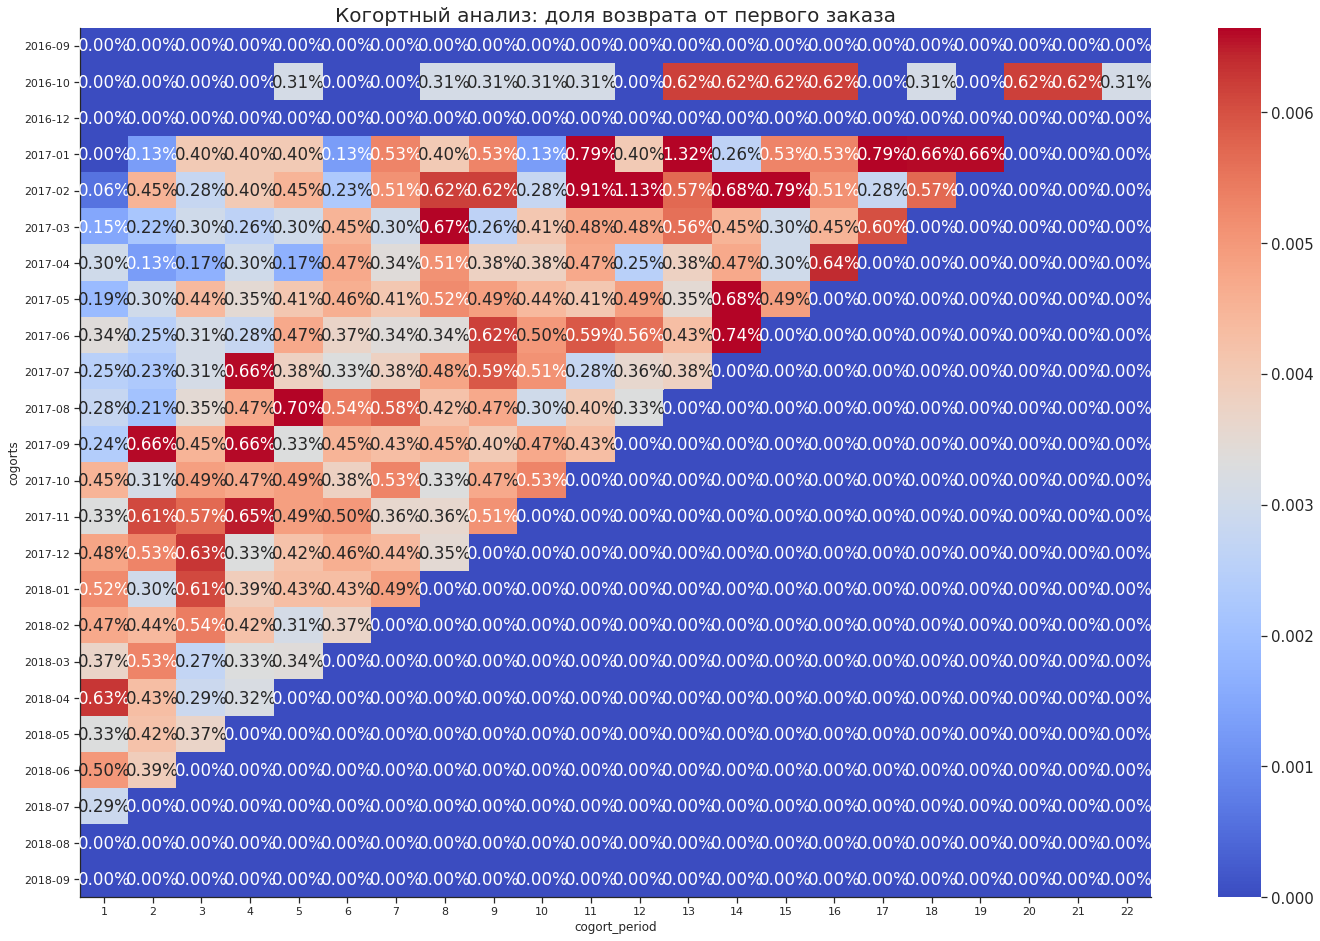

In [104]:
plt.figure(figsize=(24, 16))
sns.set(style='ticks')
plt.title('Когортный анализ: доля возврата от первого заказа', fontsize=20)

sns.set(
    font_scale=1.4,
    rc={'ytick.labelsize': 15}
        )

matrix = np.triu(cogorta_retention.isna())
sns.heatmap(cogorta_retention, mask=matrix, robust=True, annot=True, fmt='.2%', cmap='coolwarm')
sns.despine()
plt.show()

## Вывод

#### В период с января по декабрь с самым высоким retention на 3й месяц является 0.43% от 2017-09.

## 6. 

Часто для качественного анализа аудитории использую подходы, основанные на сегментации. 

Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. 

В кластеризации можешь выбрать следующие метрики:

R - время от последней покупки пользователя до текущей даты, 

F - суммарное количество покупок у пользователя за всё время, 

M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры.

Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров.

Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, 
frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. 

Займусь предобработкой данных

In [105]:
# потребуются customer_unique_id, order_id, order_approved_at and price
# считаю, что покупкой является заказ после оплаты

df_6 = merge_df.merge(order_items, how='inner', on='order_id')
df_6.shape

(112650, 20)

In [106]:
columns = ['customer_unique_id', 'order_id', 'order_approved_at', 'price']
df_rfm = df_6[columns]
df_rfm.shape

(112650, 4)

In [107]:
# для дальнейшего анализа данных убираю строки, где нет даты оплаты 
df_rfm = df_rfm.query('order_approved_at != "NaT"')
df_rfm.shape

(112635, 4)

In [108]:
df_rfm.head()

,customer_unique_id,order_id,order_approved_at,price
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:22:12,124.99
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:58:32,289.00
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-20 16:19:10,139.94
3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,2018-03-13 17:29:19,149.94
4,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 10:10:09,230.00


In [109]:
# Для определения давности клиентов нахожу самую позднюю дату покупки среди всех продаж и фиксирую ее в качестве точки отсчета 
# привожу привычный нам формат даты: год-месяц-день

df_rfm['order_approved_at'] = df_6.order_approved_at.dt.to_period("d")
now_date                    = df_rfm.sort_values('order_approved_at').order_approved_at.max()
df_rfm['now_date']          = now_date

df_rfm.shape

(112635, 5)

In [110]:
df_rfm.head()

,customer_unique_id,order_id,order_approved_at,price,now_date
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16,124.99,2018-09-03
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12,289.00,2018-09-03
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-20,139.94,2018-09-03
3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,2018-03-13,149.94,2018-09-03
4,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29,230.00,2018-09-03


In [111]:
# определяю дату, когда пользователь совершил свою последнюю покупку
last_date = merge_df[['customer_unique_id', 'order_approved_at']] \
.groupby('customer_unique_id') \
.max() \
.rename(columns={'customer_unique_id': 'customer_id', 'order_approved_at' : 'last_date_order'}) \
.reset_index()

# привожу к привычному формату дату: год-месяц-день
last_date['last_date_order'] = last_date.last_date_order.dt.to_period("d")

last_date.shape

(96096, 2)

In [112]:
last_date.head()

,customer_unique_id,last_date_order
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07
2,0000f46a3911fa3c0805444483337064,2017-03-10
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14


In [113]:
# добавляю в датасет rfm дату последней покупки
df_rfm = df_rfm.merge(last_date, on='customer_unique_id')
df_rfm.shape

(112635, 6)

In [116]:
df_rfm.head()

,customer_unique_id,order_id,order_approved_at,price,now_date,last_date_order
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16,124.99,2018-09-03,2017-05-16
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12,289.00,2018-09-03,2018-01-12
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-20,139.94,2018-09-03,2018-05-20
3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,2018-03-13,149.94,2018-09-03,2018-03-13
4,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29,230.00,2018-09-03,2018-07-29


In [118]:
# давность последней покупки по каждому клиенту
df_rfm['R'] = (
    df_rfm.now_date.view(dtype='int64') - df_rfm.last_date_order.view(dtype='int64')
                                        )

In [119]:
RFM = df_rfm \
.groupby('customer_unique_id', as_index=False)\
.agg({'R': 'min',
    'order_id': 'nunique',
    'price': 'sum'})\
.rename(columns={'R': 'Recency', 
                'order_id': 'Frequency', 
                'price': 'Monetary'})
RFM.shape

(95407, 4)

In [120]:
RFM.head()

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90
2,0000f46a3911fa3c0805444483337064,542,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00


Делаю визуализацию полученных данных

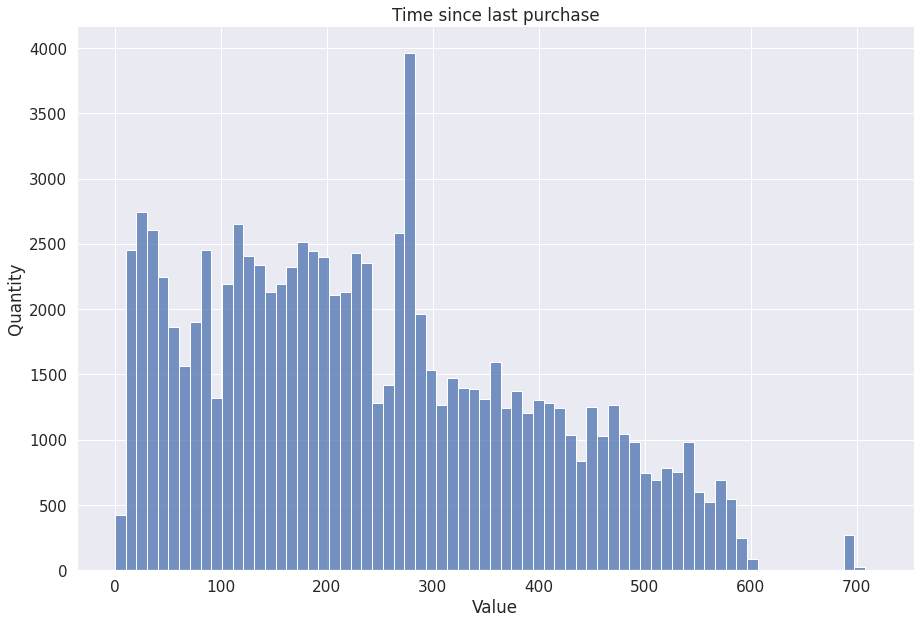

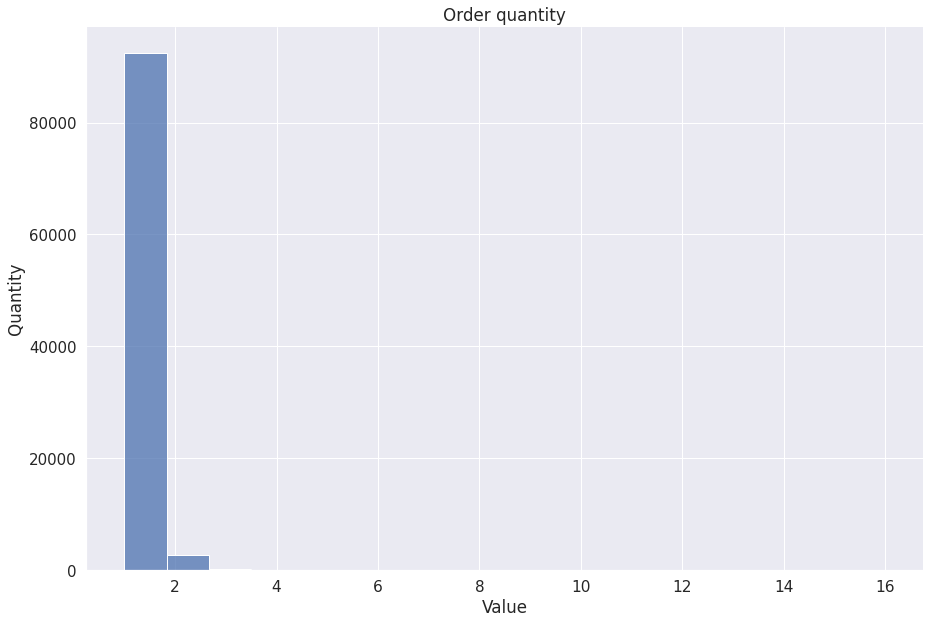

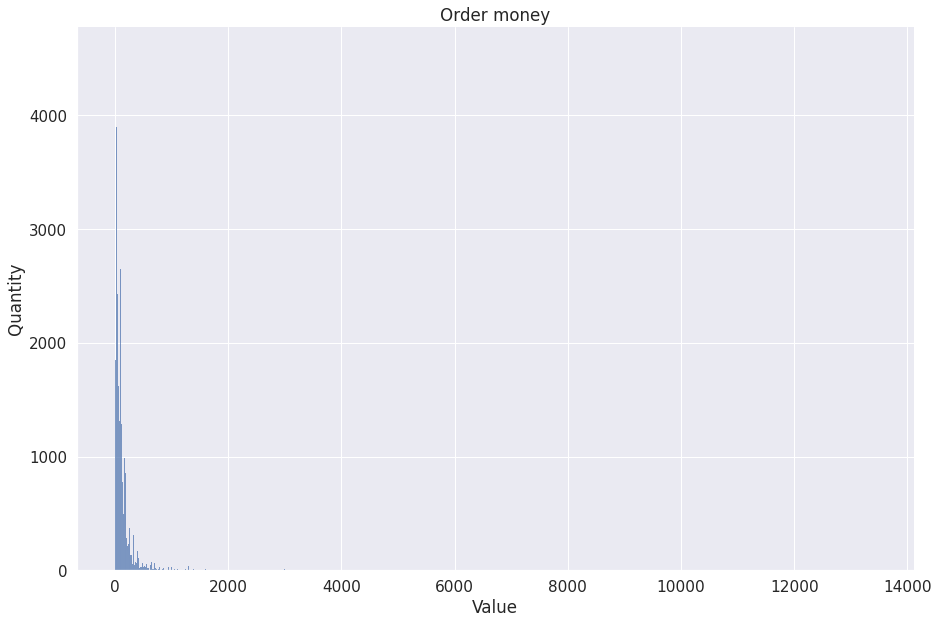

In [121]:
plt.figure(figsize=(15, 10))
sns.histplot(x = 'Recency', data = RFM)
plt.xlabel('Value')
plt.ylabel('Quantity')
plt.title('Time since last purchase')
sns.despine()
plt.show()

plt.figure(figsize=(15, 10))
sns.histplot(x = 'Frequency', data = RFM)
plt.xlabel('Value')
plt.ylabel('Quantity')
plt.title('Order quantity')
sns.despine()
plt.show()

plt.figure(figsize=(15, 10))
sns.histplot(x = 'Monetary', data = RFM)
plt.xlabel('Value')
plt.ylabel('Quantity')
plt.title('Order money')
sns.despine()
plt.show()

In [122]:
# выясняю равные границы метрики 'RFM' по квартилям
RFM.quantile(q=[0.33, 0.66])

,Recency,Frequency,Monetary
0.33,152.0,1.0,57.99
0.66,291.0,1.0,125.00


Границы метрики 'Recency' - чем больше признак метрики - тем весомее клиент

In [123]:
segment_R = {'1': 152, '2': 291}

def R_segment(x):
    if x<=segment_R['1']:
        return 3
    elif x <=segment_R['2']:
        return 2
    else:
        return 1

RFM['R_segment']=RFM['Recency'].apply(R_segment)

RFM.head()

,customer_unique_id,Recency,Frequency,Monetary,R_segment
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,3
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,3
2,0000f46a3911fa3c0805444483337064,542,1,69.00,1
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,1
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,1


Границы 'Frequency' - чем выше признак метрики, тем чаще клиент приобретает товар, тем самым - весомее

In [124]:
# смотрю детально на числовые характеристики столбца 'Frequency'
print(RFM.Frequency.describe())

# выясняю равные границы по квартилям
print(RFM.Frequency.quantile(q=[0.33, 0.66]))

count    95407.000000
mean         1.034012
std          0.211225
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         16.000000
Name: Frequency, dtype: float64
0.33    1.0
0.66    1.0
Name: Frequency, dtype: float64


In [125]:
# т.к. большинство клиентов покупают товар один раз, то границы определяю как в задании: 
# менее 2 раз, от 2 до 5 раз и свыше 5 раз
# задаю границы метрики Frequency 
segment_F = {'1': 2, '2': 5}

def F_segment(x):
    if x<=segment_F['1']:
        return 1
    elif x <=segment_F['2']:
        return 2
    else:
        return 3

RFM['F_segment']=RFM['Frequency'].apply(F_segment)

RFM.head()

,customer_unique_id,Recency,Frequency,Monetary,R_segment,F_segment
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,3,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,3,1
2,0000f46a3911fa3c0805444483337064,542,1,69.00,1,1
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,1,1
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,1,1


Границы метрики 'Monetary', чем выше признак метрики, тем больше клиент тратит на нас и тем самым весомее

In [126]:
# числовые характеристики столбца 'Monetary'
print(RFM.Monetary.describe())
# выясняю равные границы по квартилям
print(RFM.Monetary.quantile(q=[0.33, 0.66]))

count    95407.000000
mean       142.442098
std        217.667272
min          0.850000
25%         47.900000
50%         89.900000
75%        155.000000
max      13440.000000
Name: Monetary, dtype: float64
0.33     57.99
0.66    125.00
Name: Monetary, dtype: float64


In [127]:
# задаю границы метрики 'Monetary' 
segment_M = {'1': 57.99, '2': 125}

def M_segment(x):
    if x<=segment_M['1']:
        return 1
    elif x <=segment_M['2']:
        return 2
    else:
        return 3

RFM['M_segment']=RFM['Monetary'].apply(M_segment)

RFM.head()

,customer_unique_id,Recency,Frequency,Monetary,R_segment,F_segment,M_segment
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,3,1,3
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,3,1,1
2,0000f46a3911fa3c0805444483337064,542,1,69.00,1,1,2
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,1,1,1
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,1,1,3


RFM-Сегментация 

In [134]:
# RFM segment
RFM['RFM_segment']=RFM['R_segment'].astype(str)+RFM['F_segment'].astype(str)+RFM['M_segment'].astype(str)
RFM.head()

,customer_unique_id,Recency,Frequency,Monetary,R_segment,F_segment,M_segment,RFM_segment
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,3,1,3,313
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,3,1,1,311
2,0000f46a3911fa3c0805444483337064,542,1,69.00,1,1,2,112
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,1,1,1,111
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,1,1,3,113


Анализ 'RFM'

In [135]:
# топ 10 (RFM_segment = 333)
RFM[RFM['RFM_segment']=='333'].sort_values('Monetary', ascending=False).head(10)

,customer_unique_id,Recency,Frequency,Monetary,R_segment,F_segment,M_segment,RFM_segment
75550,ca77025e7201e3b30c44b472ff346268,93,7,806.61,3,3,3,333
52592,8d50f5eadf50201ccdcedfb9e2ac8455,14,16,729.62,3,3,3,333
82294,dc813062e0fc23409cd255f7f53c7074,11,6,687.76,3,3,3,333
37531,6469f99c1f9dfae7733b25662e7f1782,67,7,664.20,3,3,3,333
37319,63cfc61cee11cbe306bff5857d00bfe4,98,6,579.81,3,3,3,333
89802,f0e310a6839dce9de1638e0fe5ab282a,151,6,438.09,3,3,3,333


In [136]:
# 10 потерянных клиентов (RFM_segment = 111)
RFM[RFM['RFM_segment']=='111'].sort_values('Monetary', ascending=False).head(10)

,customer_unique_id,Recency,Frequency,Monetary,R_segment,F_segment,M_segment,RFM_segment
54122,915dc6fe6ef553bd5ac6ca1e971dd6e6,385,1,57.99,1,1,1,111
83447,df8fc9f5259ee77b678192c7c3879a94,468,1,57.99,1,1,1,111
89776,f0d35e234997ee63e62d77f2c863fd3c,297,1,57.99,1,1,1,111
7228,133e7e64acd392c91ef17dc92fcd0128,356,1,57.99,1,1,1,111
46595,7cbeb3b26200ff0b044810d637e54b3c,363,1,57.99,1,1,1,111
46650,7cdcdb5976a5be4c23883f6d3a288ad6,467,1,57.99,1,1,1,111
19872,3517e4c452bc29782db762a150996061,362,1,57.99,1,1,1,111
32143,560046dc7dd7b822bb2f7f1e5e33a2c8,555,1,57.99,1,1,1,111
58025,9b874554bd1f4a4b62c06f57ccc288f4,574,1,57.99,1,1,1,111
27953,4acdcee4311f692f664898fd366b9157,349,1,57.99,1,1,1,111


In [137]:
# топ 10 лояльных клиентов (F_segment > 2)
RFM[(RFM['F_segment']>=2) & (RFM['R_segment']>2)].sort_values('Monetary', ascending=False).head(10)

,customer_unique_id,Recency,Frequency,Monetary,R_segment,F_segment,M_segment,RFM_segment
74743,c8460e4251689ba205045f3ea17884a1,25,4,4080.00,3,2,3,323
29774,4facc2e6fbc2bffab2fea92d2b4aa7e4,21,4,1686.90,3,2,3,323
21491,397b44d5bb99eabf54ea9c2b41ebb905,78,4,1650.00,3,2,3,323
94850,fe81bb32c243a86b2f86fbf053fe6140,74,5,1535.40,3,2,3,323
15482,297ec5afd18366f5ba27520cc4954151,114,3,1392.44,3,2,3,323
78996,d387ea85dc301a91740e31360d355686,97,3,1216.90,3,2,3,323
29190,4e1cce07cd5937c69dacac3c8b13d965,33,3,1216.60,3,2,3,323
78081,d132b863416f85f2abb1a988ca05dd12,44,3,1202.73,3,2,3,323
19109,33176de67c05eeed870fd49f234387a0,89,3,1021.50,3,2,3,323
56745,9832ae2f7d3e5fa4c7a1a06e9551bc61,132,3,978.48,3,2,3,323


In [138]:
# распределение клиентов по RFM-сегментам 
Segments = RFM\
              .groupby('RFM_segment', as_index = False) \
              .agg({'customer_unique_id': 'count'}) \
              .rename(columns = {'customer_unique_id' : 'client'})
Segments

,RFM_segment,client
0,111,10638
1,112,10958
2,113,10757
3,121,5
4,122,6
5,123,54
6,132,1
7,211,10609
8,212,10094
9,213,10666


Делаю визуализацию на построенных данных

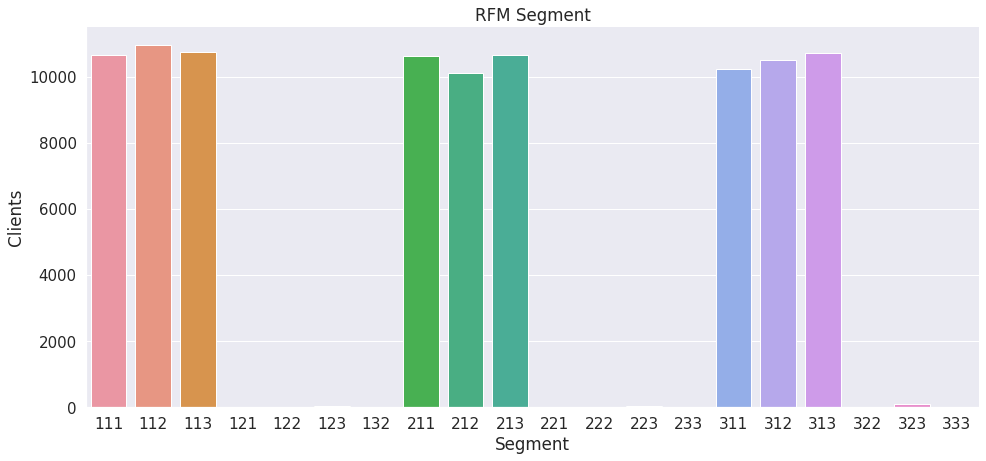

In [140]:
plt.figure(figsize=(16, 7))
sns.barplot(x = 'RFM_segment', y='client', data = Segments)
plt.xlabel('Segment')
plt.ylabel('Clients')
plt.title('RFM Segment')
sns.despine()
plt.show()

## выводы:

#### Примерно одинаково покупатели распределились между сегментами 111, 112, 113, 211, 212, 213, 311, 312 и 313
#### Несмотря на то, что в большинстве своем клиенты покупали товар разово, у нас все равно имеются лояльные клиенты, которые
#### покупают товар неоднократно и можно вполне анализировать